In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, ConcatDataset, TensorDataset, DataLoader, Dataset, Subset
from matplotlib import animation
import os
import wandb
import h5py
from pathlib import Path

print("PyTorch Version: ",torch.__version__)
print("Cuda available: ",torch.cuda.is_available())
print("Cuda Version: ",torch.version.cuda)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#from dataloaders.SimpleLoaderBubbleML import *
from modelComp.UNet import *

PyTorch Version:  2.4.1+cu121
Cuda available:  True
Cuda Version:  12.1


In [2]:
twall_100 = h5py.File('C:/Users/tphar/Documents/2024-II/AutoregressiveNeuralOperators/data/PoolBoiling-SubCooled-FC72-2D/Twall-100.hdf5', 'r')

# Print all keys in the file
print("Keys in the HDF5 file:")
for key in twall_100.keys():
    print(key)

# Access one specific dataset for further processing
real_runtime_params = twall_100['real-runtime-params'][:]
key0, val0 = real_runtime_params[0]
int_runtime_params = twall_100['int-runtime-params'][:]
key1, val1 = real_runtime_params[0]

print(f'\nMetadata size: {real_runtime_params.shape}')
print(f'Key type: {type(key0)}')
print(f'Val type: {type(val0)}')

def key_to_str(key):
    # Convert byte string to a standard python utf-8 string.
    return key.decode('utf-8').strip()

# Convert to a dict of (string, float64)
runtime_param_dict = dict([(key_to_str(key), val) for (key, val) in real_runtime_params])
int_param_dict = dict([(key_to_str(key), val) for (key, val) in int_runtime_params])

# Print the Reynolds number
inv_reynolds = runtime_param_dict['ins_invreynolds']
print(f'\nReynolds Number: {1 / inv_reynolds}')
print()
for key, val in runtime_param_dict.items():
    print(f'{key}: {val}')

print()

for key, val in int_param_dict.items():
    print(f'{key}: {val}')

Keys in the HDF5 file:
dfun
int-runtime-params
pressure
real-runtime-params
temperature
velx
vely
x
y

Metadata size: (109,)
Key type: <class 'numpy.bytes_'>
Val type: <class 'numpy.float64'>

Reynolds Number: 238.0952380952381

checkpointfileintervaltime: 5.0
checkpointfileintervalz: 1.7976931348623157e+308
derefine_cutoff_1: 0.2
derefine_cutoff_2: 0.2
derefine_cutoff_3: 0.2
derefine_cutoff_4: 0.2
dr_dtmincontinue: 0.0
dr_tstepslowstartfactor: 0.1
dtinit: 0.0001
dtmax: 0.0004
dtmin: 1e-10
gr_amrexmg_tol: 1e-13
gr_btworkchildscaling: 1.0
gr_btworkdefaultleaf: 2.0
gr_btworkdefaultpar: 1.0
gr_btworklbleaf: 0.0
gr_btworklbpar: 0.0
gr_btworkubleaf: 1000000.0
gr_btworkubpar: 1000000.0
gr_lrefinemaxredlogbase: 10.0
gr_lrefinemaxredradiusfact: 0.0
gr_lrefinemaxredtref: 0.0
gr_lrefinemaxredtimescale: 1.0
gr_lrefmaxtime_1: -1.0
gr_lrefmaxtime_10: -1.0
gr_lrefmaxtime_11: -1.0
gr_lrefmaxtime_12: -1.0
gr_lrefmaxtime_13: -1.0
gr_lrefmaxtime_14: -1.0
gr_lrefmaxtime_15: -1.0
gr_lrefmaxtime_16: -1.0
g

In [3]:
TEMPERATURE = 'temperature'
VELX = 'velx'
VELY = 'vely'
PRESSURE = 'pressure'


class SimpleLoaderBubbleML(Dataset):
    def __init__(self, filename):
        self.filename = filename
        self.data = h5py.File(self.filename, 'r')
        self.timesteps = self.data[TEMPERATURE][:].shape[0]
        print(Path(filename).stem)
        print(self.data[TEMPERATURE][:].max())
        
    
    def __len__(self):
        return self.timesteps - 1

    def _get_state(self, idx):
        r"""
        The input is the temperature, x-velocity, and y-velocity at time == idx
        """
        temp = torch.from_numpy(self.data[TEMPERATURE][idx])
        velx = torch.from_numpy(self.data[VELX][idx])
        vely = torch.from_numpy(self.data[VELY][idx])
        return torch.stack((temp, velx, vely), dim=0)
    
    def __getitem__(self, idx):
        r"""
        As input, get temperature and velocities at time == idx.
        As the output label, get the temperature at time == idx + 1.
        """
        input = self._get_state(idx)
        label = self._get_state(idx+1)
        return input, label
    
    def get_full_stack(self):
        r"""
        Retrieve the full temporal domain stack for the entire simulation.
        The returned stack will have shape: [timesteps, channels, Y, X].
        """
        temp_data = torch.from_numpy(self.data[TEMPERATURE][:])  
        velx_data = torch.from_numpy(self.data[VELX][:])         
        vely_data = torch.from_numpy(self.data[VELY][:])       
        
        full_stack = torch.stack((temp_data, velx_data, vely_data), dim=1)
        return full_stack

    


In [4]:
dataPath = 'C:/Users/tphar/Documents/2024-II/AutoregressiveNeuralOperators/data/PoolBoiling-SubCooled-FC72-2D/'
downsampled = True

dataPath = dataPath + 'downsampled_redimensionalized/' if downsampled else dataPath
train_files = ['Twall-95.hdf5', 'Twall-98.hdf5', 'Twall-103.hdf5', 'Twall-106.hdf5']
train_files = [dataPath + file for file in train_files]

val_files = ['Twall-100.hdf5']
val_files = [dataPath + file for file in val_files]

train_dataset = ConcatDataset(SimpleLoaderBubbleML(file) for file in train_files)
fullstack_train = SimpleLoaderBubbleML(train_files[1])
val_dataset = ConcatDataset(SimpleLoaderBubbleML(file) for file in val_files)
fullstack_val = SimpleLoaderBubbleML(val_files[0])
#dataset = SimpleLoaderBubbleML(files[0])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# take first 60% of the data for training, do not shuffle and take last 20% for validation

#total_size = len(dataset)
#train_size = int(0.8 * len(dataset))
#val_size = len(dataset) - train_size


#train_indices, val_indices = random_split(range(total_size), [train_size, val_size])


# Create Subset datasets to keep indices for mapping back to the original data
#train_dataset = Subset(dataset, train_indices.indices)
#val_dataset = Subset(dataset, val_indices.indices)







print(f'Train batches: {len(train_dataloader)}')
print(f'Val batches: {len(val_dataloader)}')

Twall-95
90.71124070636333
Twall-98
93.02668994230288
Twall-103
98.55226391151872
Twall-106
100.41837733618718
Twall-98
93.02668994230288
Twall-100
95.25298549748979
Twall-100
95.25298549748979
Train batches: 100
Val batches: 25


torch.Size([8, 3, 96, 96]) torch.Size([8, 3, 96, 96])


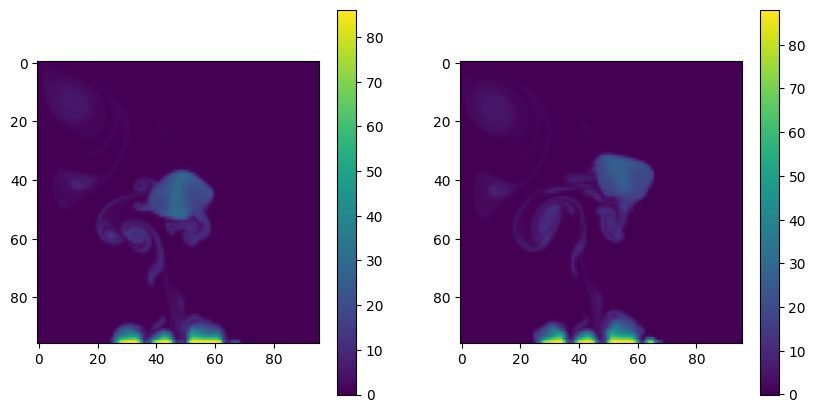

In [5]:
for batch_idx, (data, target) in enumerate(train_dataloader):
    print(data.shape, target.shape)
    break

# plot the temperature field
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
flipped_data = np.flipud(data[0, 0].numpy())
flipped_target = np.flipud(target[0, 0].numpy())
im0 = ax[0].imshow(flipped_data)
im1 = ax[1].imshow(flipped_target)
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])


plt.show()

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = UNet2D(3, 3, features=(64, 128, 256)).to(DEVICE)
print(f'The model has {count_parameters(model):,} trainable parameters')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

The model has 7,703,107 trainable parameters


In [ ]:
EPOCHS = 150

wandb.init(project="BubbleML_Unet", config={
    "epochs": EPOCHS
})

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = []
    for iter, (input, label) in enumerate(train_dataloader):
        input = input.to(DEVICE).float()
        label = label.to(DEVICE).float()
        pred = model(input)
        optimizer.zero_grad()
        loss = F.mse_loss(pred, label)
        loss.backward()
        optimizer.step()

        # Append loss for this batch
        epoch_train_loss.append(loss.item())

        
        progress = (iter + 1) / len(train_dataloader) * 100
        print(f"Epoch {epoch + 1}/{EPOCHS}, Training Progress: {progress:.2f}%", end="\r")

    # Calculate average train loss for this epoch
    avg_train_loss = torch.mean(torch.tensor(epoch_train_loss))
    train_losses.append(avg_train_loss)

    # Validation phase
    val_loss = []
    model.eval()
    with torch.no_grad():
        for iter, (input, label) in enumerate(val_dataloader):
            input = input.to(DEVICE).float()
            label = label.to(DEVICE).float()
            pred = model(input)
            loss = F.mse_loss(pred, label)
            val_loss.append(loss.item())

            print(f"Epoch {epoch + 1}/{EPOCHS}, Validation Progress: {progress:.2f}%", end="\r")

    avg_val_loss = torch.mean(torch.tensor(val_loss))
    val_losses.append(avg_val_loss)

    wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
        })

    # Print losses for the epoch
    print(f"Epoch {epoch + 1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: tpharmsen (tpharmsen-tue). Use `wandb login --relogin` to force relogin


Epoch 1/150 - Train Loss: 14.8983, Validation Loss: 13.1871
Epoch 2/150 - Train Loss: 12.4690, Validation Loss: 11.9209
Epoch 3/150 - Train Loss: 11.2266, Validation Loss: 10.5567
Epoch 4/150 - Train Loss: 9.9575, Validation Loss: 9.1155
Epoch 5/150 - Train Loss: 8.7624, Validation Loss: 8.8138
Epoch 6/150 - Train Loss: 7.6144, Validation Loss: 8.0731
Epoch 7/150 - Train Loss: 6.5755, Validation Loss: 7.6475
Epoch 8/150 - Train Loss: 5.6148, Validation Loss: 5.9507
Epoch 9/150 - Train Loss: 4.7563, Validation Loss: 5.7479
Epoch 10/150 - Train Loss: 3.9585, Validation Loss: 4.3659
Epoch 11/150 - Train Loss: 3.2674, Validation Loss: 3.7247
Epoch 12/150 - Train Loss: 2.7146, Validation Loss: 3.7300
Epoch 13/150 - Train Loss: 2.1709, Validation Loss: 3.0355
Epoch 14/150 - Train Loss: 1.7835, Validation Loss: 2.9347
Epoch 15/150 - Train Loss: 1.4881, Validation Loss: 2.9323
Epoch 16/150 - Train Loss: 1.2137, Validation Loss: 2.6428
Epoch 17/150 - Train Loss: 0.9888, Validation Loss: 2.6991


In [29]:
model.eval()

dataFull = fullstack_train.get_full_stack()
start_index = 20
input = dataFull[start_index].to(DEVICE).float()
input = input.unsqueeze(0)
timesteps = 40
predictions = []
predictions.append(input.cpu())

with torch.no_grad():
    for t in range(timesteps - 1):
        pred = model(input) 
        predictions.append(pred.cpu())
        input = pred  

stacked_predictions = torch.stack(predictions, dim=0)
stacked_predictions = stacked_predictions.squeeze(1)

min_val = min(stacked_predictions.min(), dataFull.min())
max_val = max(stacked_predictions.max(), dataFull.max())
dataFull = (dataFull - min_val) / (max_val - min_val)
stacked_predictions = (stacked_predictions - min_val) / (max_val - min_val)

fig, ax = plt.subplots(2,1, figsize=(5, 10))

def update_frame(i):
    print(i, end='\r')
    ax[0].clear()
    ax[1].clear()
    imgpred = np.flipud(stacked_predictions[i, 0, :, :].numpy())
    imgtrue = np.flipud(dataFull[i + start_index, 0, :, :].numpy()) 
    ax[0].imshow(imgtrue, cmap='jet', vmin=0, vmax=1)
    ax[0].set_title("True")
    ax[1].imshow(imgpred, cmap='jet', vmin=0, vmax=1)
    ax[1].set_title("Prediction")
    fig.suptitle(f"Step {i + 1}/{timesteps}")
    ax[0].axis('off')
    ax[1].axis('off')
    

ani = animation.FuncAnimation(fig, update_frame, frames=timesteps, interval=500)

ani.save('../output/trainUNet.gif', writer='ffmpeg', fps=10)
# dont show the plot
plt.close()


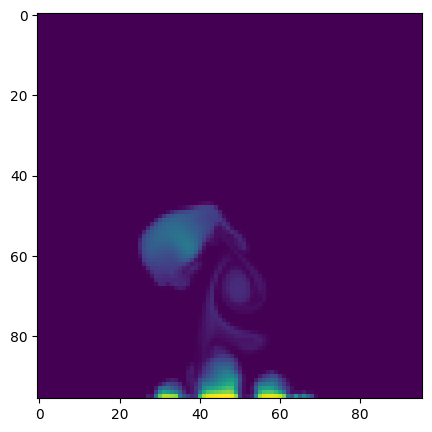

In [30]:
model.eval()

dataFull = fullstack_val.get_full_stack()
start_index = 20
input = dataFull[start_index].to(DEVICE).float()
input = input.unsqueeze(0)
timesteps = 40
predictions = []
predictions.append(input.cpu())

with torch.no_grad():
    for t in range(timesteps - 1):
        pred = model(input) 
        predictions.append(pred.cpu())
        input = pred  

stacked_predictions = torch.stack(predictions, dim=0)
stacked_predictions = stacked_predictions.squeeze(1)

min_val = min(stacked_predictions.min(), dataFull.min())
max_val = max(stacked_predictions.max(), dataFull.max())
dataFull = (dataFull - min_val) / (max_val - min_val)
stacked_predictions = (stacked_predictions - min_val) / (max_val - min_val)


fig, ax = plt.subplots(2,1, figsize=(5, 10))

def update_frame(i):
    print(i, end='\r')
    ax[0].clear()
    ax[1].clear()
    imgpred = np.flipud(stacked_predictions[i, 0, :, :].numpy())
    imgtrue = np.flipud(dataFull[i + start_index, 0, :, :].numpy()) 
    ax[0].imshow(imgtrue, cmap='jet', vmin=0, vmax=1)
    ax[0].set_title("True")
    ax[1].imshow(imgpred, cmap='jet', vmin=0, vmax=1)
    ax[1].set_title("Prediction")
    fig.suptitle(f"Step {i + 1}/{timesteps}")
    ax[0].axis('off')
    ax[1].axis('off')
    
ani = animation.FuncAnimation(fig, update_frame, frames=timesteps, interval=500)

ani.save('../output/valUNet.gif', writer='ffmpeg', fps=10)
# dont show the plot
plt.close()

# plot the temperature field
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
input = predictions[0]
flipped_data = np.flipud(input[0,0,:,:].cpu().numpy())
ax.imshow(flipped_data)

In [47]:
class FullLoaderBubbleML:
    def __init__(self, filename):
        self.filename = filename
        self.data = h5py.File(self.filename, 'r')
        self.timesteps = self.data[TEMPERATURE][:].shape[0]
        self.spatial_dims = self.data[TEMPERATURE][:].shape[1:]  # Get spatial dimensions (Y, X)
    
    def get_full_stack(self):
        """
        Retrieve the full temporal domain stack for the entire file.
        Returns a tensor with shape: [timesteps, channels, Y, X].
        """
        # Load temperature, velx, vely, and pressure data from the HDF5 file
        temp_data = torch.from_numpy(self.data[TEMPERATURE][:])  # Shape: [timesteps, Y, X]
        velx_data = torch.from_numpy(self.data[VELX][:])         # Shape: [timesteps, Y, X]
        vely_data = torch.from_numpy(self.data[VELY][:])         # Shape: [timesteps, Y, X]
        pres_data = torch.from_numpy(self.data[PRESSURE][:])     # Shape: [timesteps, Y, X]
        
        # Stack the data along the channel dimension
        full_stack = torch.stack((temp_data, velx_data, vely_data, pres_data), dim=1)  # Shape: [timesteps, channels, Y, X]
        return full_stack
    
    def get_metadata(self):
        """
        Retrieve metadata information such as the number of timesteps and spatial dimensions.
        """
        return {
            "timesteps": self.timesteps,
            "spatial_dims": self.spatial_dims
        }
    
# Initialize the loader
filename = files[0]
loader = FullLoaderBubbleML(filename)

# Get the full stack
full_stack = loader.get_full_stack()
print(f"Full stack shape: {full_stack.shape}")  # Expected: [timesteps, channels, Y, X]

# Access metadata
metadata = loader.get_metadata()
print(f"Number of timesteps: {metadata['timesteps']}")
print(f"Spatial dimensions: {metadata['spatial_dims']}")

Full stack shape: torch.Size([201, 4, 384, 384])
Number of timesteps: 201
Spatial dimensions: (384, 384)


In [ ]:
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class AutoregressiveModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(AutoregressiveModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out)

def train_autoregressive(model, dataloader, optimizer, loss_fn, max_rollout_steps):
    model.train()
    for batch in dataloader:
        inputs, targets = batch  # inputs: [batch_size, sequence_length, input_dim], targets: [batch_size, sequence_length, target_dim]
        batch_size, sequence_length, _ = inputs.size()

        optimizer.zero_grad()

        predictions = []
        current_input = inputs[:, 0:1]  # Start with the first timestep
        for t in range(max_rollout_steps):
            output = model(current_input)  # Predict the next timestep
            predictions.append(output)
            current_input = output  # Feed the prediction as the next input

        # Stack all predictions along the time dimension
        predictions = torch.cat(predictions, dim=1)  # [batch_size, max_rollout_steps, target_dim]

        # Compute loss only on the final prediction
        loss = loss_fn(predictions[:, -1], targets[:, max_rollout_steps - 1])

        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}")

# Example Usage
if __name__ == "__main__":
    # Dummy dataset
    class DummyDataset(torch.utils.data.Dataset):
        def __init__(self, num_samples, sequence_length, input_dim):
            self.data = torch.randn(num_samples, sequence_length, input_dim)
            self.targets = torch.randn(num_samples, sequence_length, input_dim)

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], self.targets[idx]

    dataset = DummyDataset(num_samples=100, sequence_length=10, input_dim=3)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    # Model, optimizer, loss function
    model = AutoregressiveModel(input_size=3, hidden_size=16, output_size=3)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # Train
    train_autoregressive(model, dataloader, optimizer, loss_fn, max_rollout_steps=5)


"""